# import and visualize oil data

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [22]:
oildata = pd.read_csv('oil.csv',sep=',',header=0,index_col=0)
oildata.head()

,OilProduction
1965,111.009135
1966,130.828434
1967,141.287088
1968,154.227775
1969,162.740865


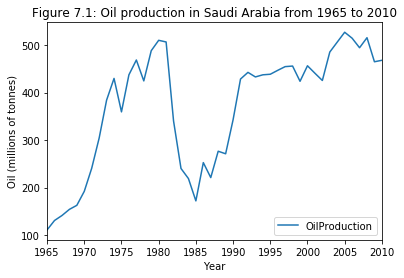

In [23]:
plt.figure();
axes = oildata.plot();
axes.set_xlabel('Year')
axes.set_ylabel('Oil (millions of tonnes)')
axes.set_title('Figure 7.1: Oil production in Saudi Arabia from 1965 to 2010');

# Reproduce plot in Figure 7.2

In [24]:
# extract data from 1996 to 2007 and perform SES
trainOilData =  oildata.loc[1996:2007].rename(index=str, columns={"OilProduction": "Observed values"})
fit1 = trainOilData.ewm(alpha=0.2,adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=0.2"})
fit2 = trainOilData.ewm(alpha=0.6,adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=0.6"})
combined = pd.concat([trainOilData,fit1,fit2],axis=1)
combined


,Observed values,alpha=0.2,alpha=0.6
1996,446.656523,446.656523,446.656523
1997,454.473307,448.219880,451.346593
1998,455.662974,449.708498,453.936422
1999,423.632239,444.493247,435.753912
2000,456.271328,446.848863,448.064362
2001,440.588050,445.596700,443.578575
2002,425.332520,441.543864,432.630942
2003,485.149448,450.264981,464.142046
2004,506.048162,461.421617,489.285715
2005,526.791983,474.495690,511.789476


In [25]:
# optimal parameter estimation in scipy
def func(x,y):
    fit = np.zeros((y.size))
    fit[0] = x[0]
    obj = (fit[0]-y[0])*(fit[0]-y[0])
    for i in range(1,y.size):
        fit[i] = x[1]*y[i-1]+(1-x[1])*fit[i-1]
        obj = obj + (fit[i]-y[i])*(fit[i]-y[i])
    return obj

bnds = ((0, 1000), (0, 1))
res = minimize(func, [trainOilData.iloc[0,0],0.5],args=trainOilData.iloc[:,0].values,bounds=bnds, method='SLSQP', options={'disp': False})
print(res.x)

[ 447.47832041    0.8920028 ]


In [26]:
# fit using optimal alpha
fit_opt = trainOilData.ewm(alpha=res.x[1],adjust=False).mean().rename(index=str, columns={"Observed values": "alpha=opt"})
combined = pd.concat([trainOilData,fit1,fit2,fit_opt],axis=1)
combined

,Observed values,alpha=0.2,alpha=0.6,alpha=opt
1996,446.656523,446.656523,446.656523,446.656523
1997,454.473307,448.219880,451.346593,453.629116
1998,455.662974,449.708498,453.936422,455.443323
1999,423.632239,444.493247,435.753912,427.067747
2000,456.271328,446.848863,448.064362,453.117423
2001,440.588050,445.596700,443.578575,441.941187
2002,425.332520,441.543864,432.630942,427.126210
2003,485.149448,450.264981,464.142046,478.883100
2004,506.048162,461.421617,489.285715,503.114411
2005,526.791983,474.495690,511.789476,524.234872


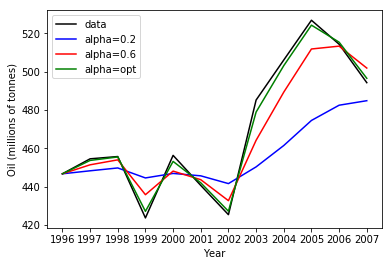

In [27]:
# plot graphs
fig, axes = plt.subplots()
axes.plot(trainOilData.index,trainOilData,color='black',label='data')
axes.plot(fit1.index,fit1,color='blue',label='alpha=0.2')
axes.plot(fit2.index,fit2,color='red',label='alpha=0.6')
axes.plot(fit_opt.index,fit_opt,color='green',label='alpha=opt')
axes.set_xlabel('Year')
axes.set_ylabel('Oil (millions of tonnes)')
axes.legend();

# Reproduce Holt's linear trend method data in Table 7.3

In [38]:
alpha = 0.8
beta_star = 0.2
airdata = pd.read_csv('ausair.csv',sep=',',header=0,index_col=0).loc[1990:2004]
air = airdata.iloc[:,0].values
years = airdata.index.values

# fit SES
fitSES = np.zeros((air.size))
fitSES[0] = air[0]
for i in range(1,air.size):
    fitSES[i] = alpha*air[i]+(1-alpha)*fitSES[i-1]
    
# fit Holt's linear trend method
fitHolt = np.zeros((air.size))
bt = np.zeros((air.size))
yt = np.zeros((air.size))
fitHolt_o = air[0] # note that level is plotted
b_o = air[1]-air[0]
yt[0] = fitHolt_o+b_o
fitHolt[0] = alpha*air[0]+(1-alpha)*yt[0]
bt[0] = beta_star*(fitHolt[0]-fitHolt_o)+(1-beta_star)*b_o
for i in range(1,air.size):
    yt[i] = fitHolt[i-1]+bt[i-1]
    fitHolt[i] = alpha*air[i]+(1-alpha)*yt[i]
    bt[i] = beta_star*(fitHolt[i]-fitHolt[i-1])+(1-beta_star)*bt[i-1]

# tabulate
combined_SES_Holt = np.column_stack((air,fitHolt,fitSES))
combined_SES_Holt

array([[ 17.5534    ,  18.41474   ,  17.5534    ],
       [ 21.8601    ,  21.8945536 ,  20.99876   ],
       [ 23.8866    ,  24.20620374,  23.309032  ],
       [ 26.9293    ,  27.05155717,  26.2052464 ],
       [ 26.8885    ,  27.56842671,  26.75184928],
       [ 28.8314    ,  29.11733235,  28.41548986],
       [ 30.0751    ,  30.3763243 ,  29.74317797],
       [ 30.9535    ,  31.2826468 ,  30.71143559],
       [ 30.1857    ,  30.79700781,  30.29084712],
       [ 31.5797    ,  31.71727076,  31.32192942],
       [ 32.577569  ,  32.67760723,  32.32644108],
       [ 33.477398  ,  33.57353161,  33.24720662],
       [ 39.021581  ,  38.17268151,  37.86670612],
       [ 41.386432  ,  41.12021621,  40.68248682],
       [ 41.596552  ,  41.92041367,  41.41373896]])

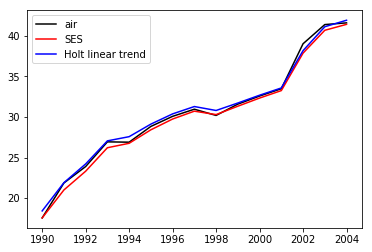

In [37]:
# visualize
plt.plot(years,air,color='black',label='air')
plt.plot(years,fitSES,color='red',label='SES')
plt.plot(years,fitHolt,color='blue',label='Holt linear trend')
plt.legend(loc='best')